#Student Name: Vipul Popat
#Student ID: 18195121

Dataset : https://archive.ics.uci.edu/ml/datasets/Autism+Screening+Adult

It's not intended to be the most accurate Autism detection model out there, but to explain how to create, visualise and understand Classification Trees. 




In [1]:
# Imports needed for the script
import numpy as np
import pandas as pd
import re
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

%matplotlib inline

from sklearn import tree
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix

from IPython.display import SVG
from graphviz import Source
from dtreeviz.trees import *



In [2]:
# Loading the data
data = pd.read_csv('autism_data.csv', header=None, names=['A1','A2','A3','A4','A5','A6','A7','A8','A9','A10','age','gender','ethnicity','born_with_jaundice','family_mem_with_pdd','country_of_residence','used_scr_app_before','screening_result','age_desc','relation','class_asd'], dtype={'ethnicity':str, 'A1':int,'A2':int,'A3':int,'A4':int,'A5':int,'A6':int,'A7':int,'A8':int,'A9':int,'A10':int})
#data = pd.read_csv('autism_data.csv', header=None, dtype=['A1':int,'A2':int,'A3':int,'A4':int,'A5':int,'A6':int,'A7':int,'A8':int,'A9':int,'A10':int,'age':int,'gender':str,'ethnicity':str,'born_with_jaundice':str,'family_mem_with_pdd':str,'country_of_residence':str,'used_scr_app_before':str,'screening_result':int,'age_desc':str,'relation':str,'class_asd':str])
data.replace('?', np.nan, inplace=True)
data.age = pd.to_numeric(data.age, errors='coerce')


null_counts = data.isnull().sum()
print("Number of null values in each column:\n{}".format(null_counts))

Number of null values in each column:
A1                       0
A2                       0
A3                       0
A4                       0
A5                       0
A6                       0
A7                       0
A8                       0
A9                       0
A10                      0
age                      2
gender                   0
ethnicity               95
born_with_jaundice       0
family_mem_with_pdd      0
country_of_residence     0
used_scr_app_before      0
screening_result         0
age_desc                 0
relation                95
class_asd                0
dtype: int64


In [3]:
print(data.columns.tolist())
data.head(5)

['A1', 'A2', 'A3', 'A4', 'A5', 'A6', 'A7', 'A8', 'A9', 'A10', 'age', 'gender', 'ethnicity', 'born_with_jaundice', 'family_mem_with_pdd', 'country_of_residence', 'used_scr_app_before', 'screening_result', 'age_desc', 'relation', 'class_asd']


,A1,A2,A3,A4,A5,A6,A7,A8,A9,A10,...,gender,ethnicity,born_with_jaundice,family_mem_with_pdd,country_of_residence,used_scr_app_before,screening_result,age_desc,relation,class_asd
0,1,1,1,1,0,0,1,1,0,0,...,f,White-European,no,no,'United States',no,6,'18 and more',Self,NO
1,1,1,0,1,0,0,0,1,0,1,...,m,Latino,no,yes,Brazil,no,5,'18 and more',Self,NO
2,1,1,0,1,1,0,1,1,1,1,...,m,Latino,yes,yes,Spain,no,8,'18 and more',Parent,YES
3,1,1,0,1,0,0,1,1,0,1,...,f,White-European,no,yes,'United States',no,6,'18 and more',Self,NO
4,1,0,0,0,0,0,0,1,0,0,...,f,NaN,no,no,Egypt,no,2,'18 and more',NaN,NO


In [4]:
# making a copy of the train data set for future use
original_data = data.copy()

In [5]:
# Getting a range of data with unique values and count for each column
for col in data.columns:
    print(data[col].value_counts())

1    508
0    196
Name: A1, dtype: int64
0    385
1    319
Name: A2, dtype: int64
0    382
1    322
Name: A3, dtype: int64
0    355
1    349
Name: A4, dtype: int64
0    353
1    351
Name: A5, dtype: int64
0    504
1    200
Name: A6, dtype: int64
0    410
1    294
Name: A7, dtype: int64
1    457
0    247
Name: A8, dtype: int64
0    476
1    228
Name: A9, dtype: int64
1    404
0    300
Name: A10, dtype: int64
21.0     49
20.0     46
23.0     37
22.0     37
19.0     35
24.0     34
27.0     31
18.0     31
30.0     30
26.0     28
25.0     27
29.0     27
28.0     24
31.0     21
32.0     18
17.0     18
35.0     17
37.0     17
40.0     16
33.0     16
42.0     15
36.0     13
38.0     12
34.0     12
43.0     11
44.0     10
47.0      8
39.0      7
46.0      6
53.0      6
55.0      6
50.0      5
52.0      5
45.0      4
48.0      4
41.0      3
49.0      3
54.0      2
61.0      2
56.0      2
58.0      2
64.0      1
59.0      1
60.0      1
51.0      1
383.0     1
Name: age, dtype: int64
m    367
f   

In [6]:
#mapping of relevant entries
ethnicity_mapping = {"'Middle Eastern '": 1, "'South Asian'": 2, "Others": 3, "Asian": 4, "Black": 5, "Hispanic": 6, "Latino": 7, "Pasifika": 8, "Turkish": 9, "White-European": 10}
data.ethnicity = data.ethnicity.replace(['others',np.nan],'Others')
data.ethnicity = data.ethnicity.replace(ethnicity_mapping)

gender_mapping = {"f" : 1, "m" : 0}
data.gender = data.gender.replace(gender_mapping)

#print(data.dtypes)
print(data.age.sum())
print(data.age.mean())
print("Age mean = ", data.age.mean(), type(data.age.mean()))
#data.age.fillna(data.age.mean().astype(int), inplace=True)
data.age.fillna(int(data.age.mean()), inplace=True)

jaundince_mapping = {"yes" : 1, "no" : 0}
data.born_with_jaundice = data.born_with_jaundice.replace(jaundince_mapping)

family_mem_with_pdd_mapping = {"yes" : 1, "no" : 0}
data.family_mem_with_pdd = data.family_mem_with_pdd.replace(family_mem_with_pdd_mapping)

class_asd_mapping = {"YES" : 1, "NO" : 0}
data.class_asd = data.class_asd.replace(class_asd_mapping)





20848.0
29.698005698005698
Age mean =  29.698005698005698 <class 'float'>


We also need to detect outliers and remove them from the dataset. We would strip the dataset of the samples lying in the first and the fourth quartile

In [7]:
def drop_outliers(df, field_name):
    distance = 1.5 * (np.percentile(df[field_name], 85) - np.percentile(df[field_name], 15))
    df.drop(df[df[field_name] > distance + np.percentile(df[field_name], 85)].index, inplace=True)
    df.drop(df[df[field_name] < np.percentile(df[field_name], 15) - distance].index, inplace=True)
    
print("Data Shape = ", data.shape)
drop_outliers(data, 'age')
print("Data Shape after removing outliers = ", data.shape)

# Getting a range of data with unique values and count for each column without the outliers
for col in data.columns:
    print(data[col].value_counts())

Data Shape =  (704, 21)
Data Shape after removing outliers =  (703, 21)
1    507
0    196
Name: A1, dtype: int64
0    384
1    319
Name: A2, dtype: int64
0    381
1    322
Name: A3, dtype: int64
0    354
1    349
Name: A4, dtype: int64
0    352
1    351
Name: A5, dtype: int64
0    503
1    200
Name: A6, dtype: int64
0    409
1    294
Name: A7, dtype: int64
1    457
0    246
Name: A8, dtype: int64
0    475
1    228
Name: A9, dtype: int64
1    404
0    299
Name: A10, dtype: int64
21.0    49
20.0    46
23.0    37
22.0    37
19.0    35
24.0    34
27.0    31
18.0    31
30.0    30
29.0    29
26.0    28
25.0    27
28.0    24
31.0    21
17.0    18
32.0    18
37.0    17
35.0    17
40.0    16
33.0    16
42.0    15
36.0    13
34.0    12
38.0    12
43.0    11
44.0    10
47.0     8
39.0     7
46.0     6
55.0     6
53.0     6
50.0     5
52.0     5
48.0     4
45.0     4
49.0     3
41.0     3
56.0     2
61.0     2
58.0     2
54.0     2
64.0     1
60.0     1
59.0     1
51.0     1
Name: age, dtype: int6

In [8]:
# Feature selection: remove variables no longer containing relevant information
# Personally I do not think these variables would make any different to the result
drop_columns = ['country_of_residence', 'used_scr_app_before', 'screening_result', 'age_desc', 'relation']
data = data.drop(drop_columns, axis=1)
print(len(data.columns))

train, test = train_test_split(data, test_size=0.2)
train.isna().sum()

data_x = data.drop(['class_asd'], axis=1)
data_y = data["class_asd"]

16


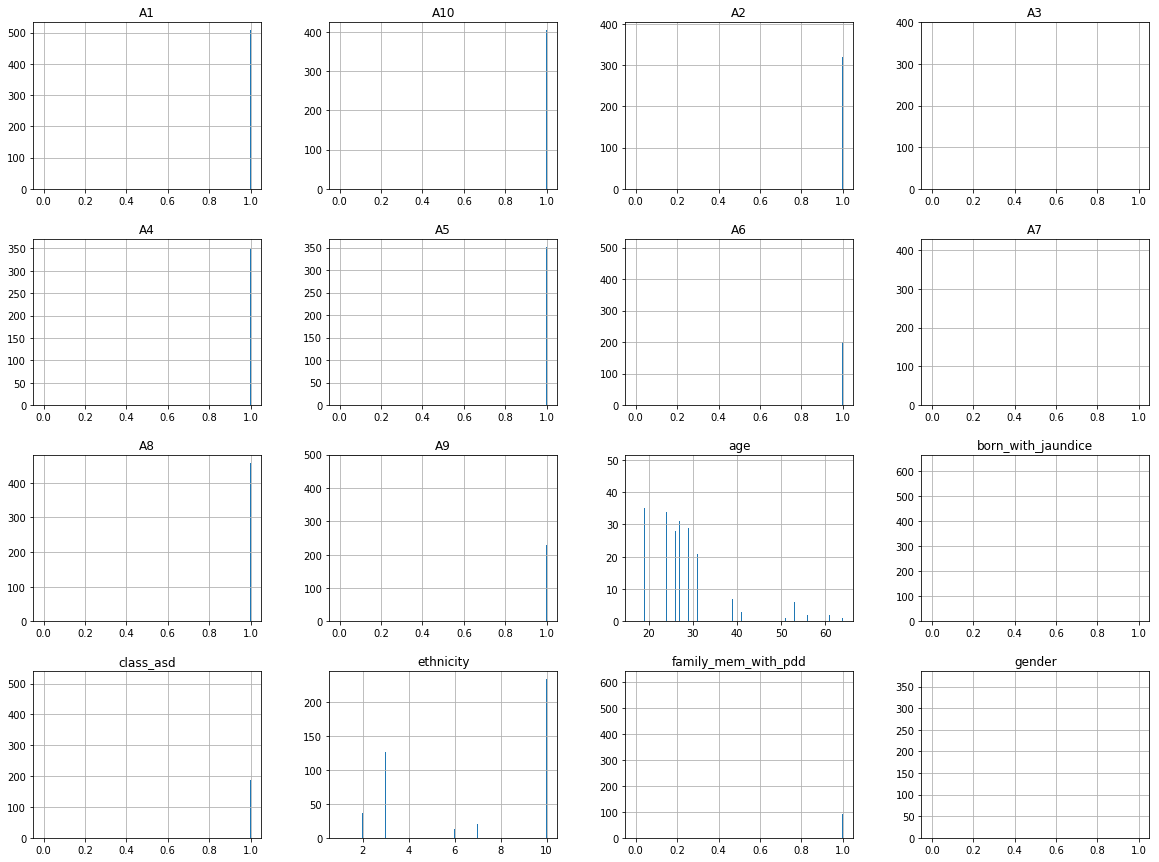

In [9]:
data.hist(bins=700, figsize=(20,15))
plt.show()

**Data Normalization**
As we are using the Decision Trees for model generation, normalization of data wont make any difference. It greatly improves the model when using SVM but not in case of Decision Trees. Refer https://sebastianraschka.com/faq/docs/when-to-standardize.html

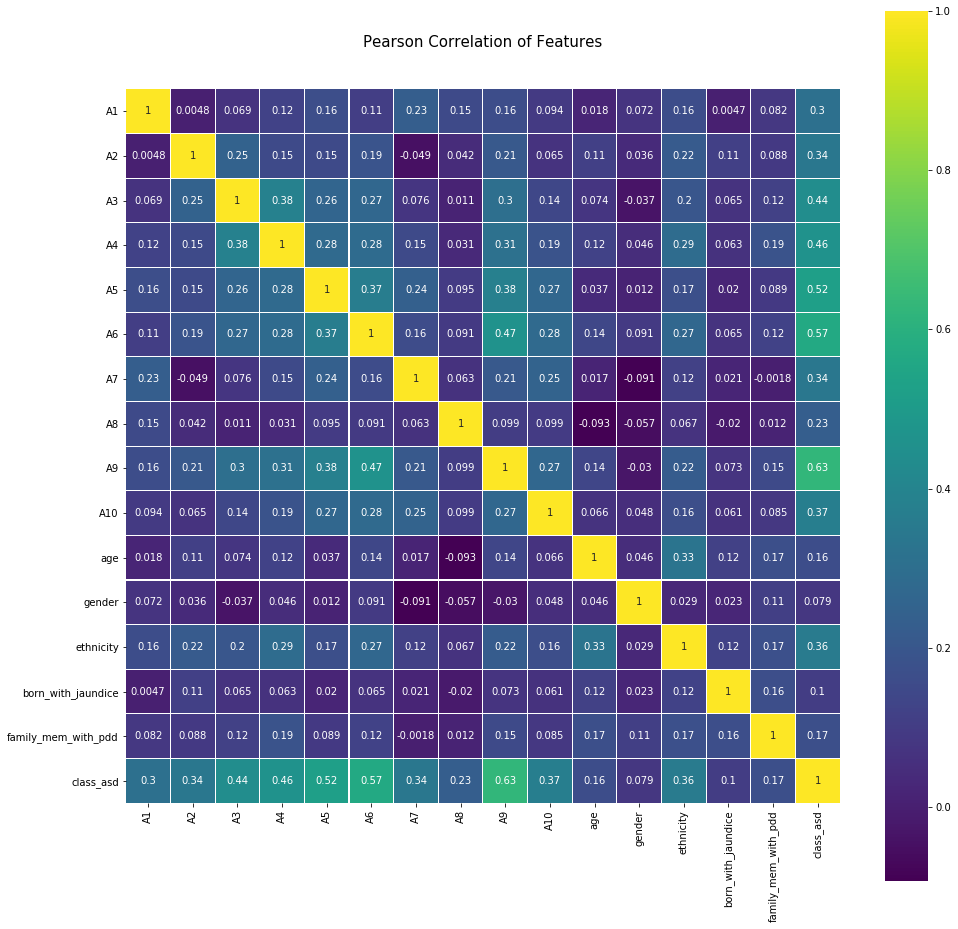

In [10]:
colormap = plt.cm.viridis
plt.figure(figsize=(16,16))
plt.title('Pearson Correlation of Features', y=1.05, size=15)
sns.heatmap(train.astype(float).corr(),linewidths=0.1,vmax=1.0, square=True, cmap=colormap, linecolor='white', annot=True)

This heatmap is very useful as an initial observation because you can easily get an idea of the predictive value of each feature. In this case, A9 & A6 show the highest correlations (in absolute terms) with the class (ASD): 0.62 and 0.60 respectively. High chances are one of them will be used for the first node in our final decision tree, so let's first explore further these features and compare them.

***Gini Impurity***

Before start working with Decision Trees, let's briefly explain how they work. The goal of their learning algorithms is always to find the best split for each node of the tree. But measuring the "goodness" of a given split is a subjective question so, in practice, different metrics are used for evaluating splits. One commonly used metric is Information Gain. The sklearn library we're gonna use implements Gini Impurity, another common measure, so let’s explain it.

Gini Impurity measures the disorder of a set of elements. It is calculated as the probability of mislabelling an element assuming that the element is randomly labelled according the the distribution of all the classes in the set. Decision Trees will try to find the split which decreases Gini Impurity the most across the two resulting nodes. For the autism dataset example it can be calculated as follows (code should be explicit enough):

In [11]:
# Define function to calculate Gini Impurity
def get_gini_impurity(asd_positive_count, total_count):
    asd_prob = asd_positive_count/total_count
    not_asd_prob = (1 - asd_prob)
    random_observation_asd_prob = asd_prob
    random_observation_not_asd_prob = (1 - random_observation_asd_prob)
    mislabelling_asd_prob = not_asd_prob * random_observation_asd_prob
    mislabelling_not_asd_prob = asd_prob * random_observation_not_asd_prob
    gini_impurity = mislabelling_asd_prob + mislabelling_not_asd_prob
    return gini_impurity

In [12]:
train.class_asd.value_counts()

0    405
1    157
Name: class_asd, dtype: int64

In [13]:
# Gini Impurity of starting node
gini_impurity_starting_node = get_gini_impurity(153, 562)
gini_impurity_starting_node

0.3962525803877864

In [14]:
train.head(5)

,A1,A2,A3,A4,A5,A6,A7,A8,A9,A10,age,gender,ethnicity,born_with_jaundice,family_mem_with_pdd,class_asd
419,1,0,0,0,1,0,1,0,0,1,20.0,0,1,0,0,0
198,1,1,1,0,1,1,0,1,1,0,31.0,0,10,0,0,1
450,1,1,0,0,0,0,0,1,0,0,19.0,1,1,0,0,0
396,1,1,1,0,1,0,0,0,0,0,20.0,1,4,0,0,0
557,1,1,0,1,1,0,0,0,0,0,29.0,0,9,0,0,0


In [15]:
cv = KFold(n_splits=10)            # Desired number of Cross Validation folds
accuracies = list()
max_attributes = len(list(test))
depth_range = range(1, max_attributes + 1)

# Testing max_depths from 1 to max attributes
for depth in depth_range:
    fold_accuracy = []
    tree_model = tree.DecisionTreeClassifier(max_depth = depth)
    # print("Current max depth: ", depth, "\n")
    for train_fold, valid_fold in cv.split(train):
        f_train = train.iloc[train_fold] # Extract train data with cv indices
        f_valid = train.iloc[valid_fold] # Extract valid data with cv indices

        model = tree_model.fit(X = f_train.drop(['class_asd'], axis=1), 
                               y = f_train["class_asd"]) # We fit the model with the fold train data
        valid_acc = model.score(X = f_valid.drop(['class_asd'], axis=1), 
                                y = f_valid["class_asd"])# We calculate accuracy with the fold validation data
        fold_accuracy.append(valid_acc)

    avg = sum(fold_accuracy)/len(fold_accuracy)
    accuracies.append(avg)
    
# Just to show results conveniently
df = pd.DataFrame({"Max Depth": depth_range, "Average Accuracy": accuracies})
df = df[["Max Depth", "Average Accuracy"]]
print(df.to_string(index=False))

Max Depth  Average Accuracy
        1          0.813315
        2          0.845238
        3          0.870113
        4          0.873590
        5          0.898559
        6          0.893170
        7          0.900407
        8          0.898590
        9          0.900313
       10          0.909242
       11          0.898528
       12          0.905702
       13          0.900376
       14          0.909179
       15          0.902036
       16          0.898528


The best max_depth parameter seems therefore to be 4 (around 90% average accuracy across the 10 folds), and feeding the model with more data results in worst results probably due to over-fitting. We'll therefore use 3 as the max_depth parameter for our final model.

Result : 6 out of 141 are wrong


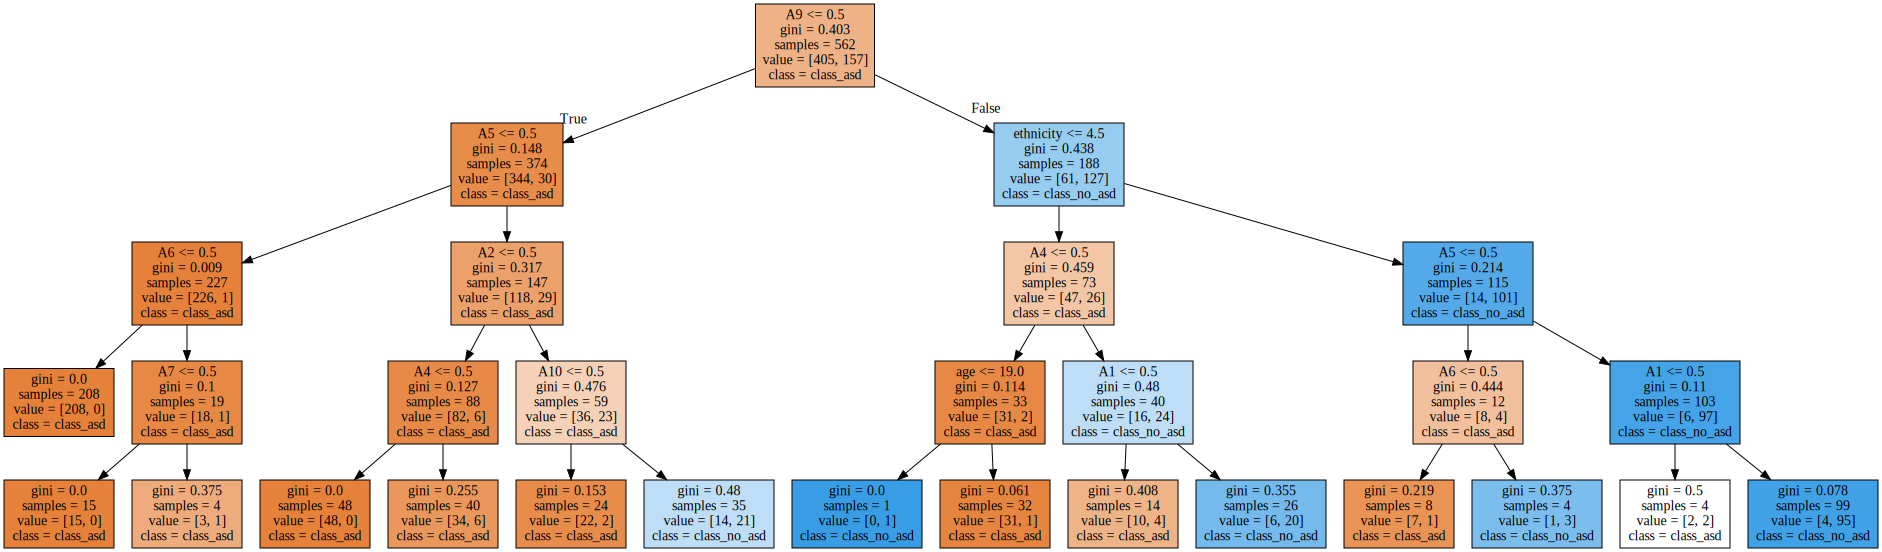

In [16]:
# Create Numpy arrays of train, test and target (class_asd) dataframes to feed into our models
y_train = train['class_asd']
x_train = train.drop(['class_asd'], axis=1).values 
x_test = test.drop(['class_asd'], axis=1).values
x_result = test['class_asd'].values

tree_depth_assumed = 4

# Create Decision Tree with max_depth = tree_depth_assumed
decision_tree = tree.DecisionTreeClassifier(max_depth = tree_depth_assumed)
decision_tree.fit(x_train, y_train)

# Predicting results for test dataset
y_pred = decision_tree.predict(x_test)
print("Result : {} out of {} are wrong".format(abs((x_result - y_pred).sum()), len(x_result)))

# class labels
labels = list(data_x.columns.values)
result_classnames = ['class_asd', 'class_no_asd']

graph = Source(tree.export_graphviz(decision_tree, out_file=None
   , feature_names=labels, class_names=result_classnames 
   , filled = True))
display(SVG(graph.pipe(format='svg')))



Visulation of the separation of results using the decision tree built model for the entire dataset

/home/vipulpopat/Tools/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1238: UserWarning: findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


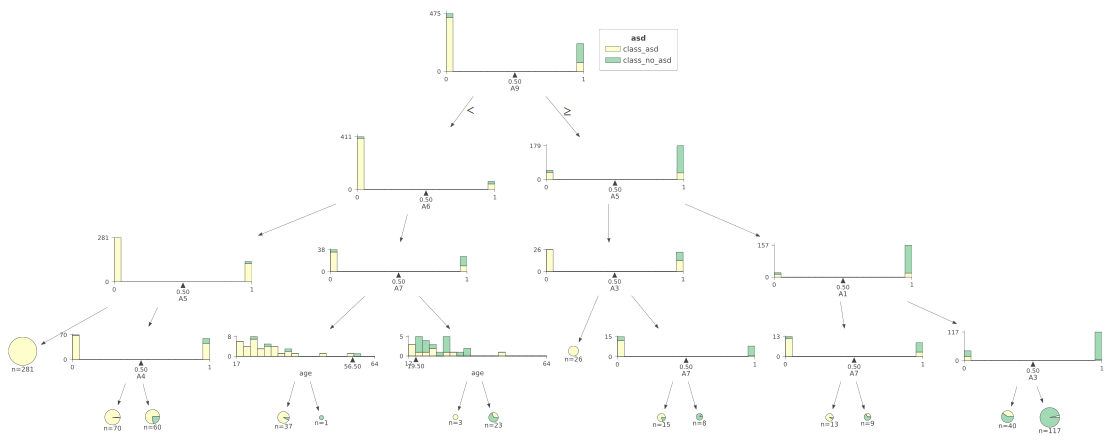

In [17]:
clf = tree.DecisionTreeClassifier(max_depth=tree_depth_assumed)
clf.fit(data_x, data_y)

viz = dtreeviz(clf, data_x, data_y, target_name='asd',
              feature_names=labels,
              class_names=result_classnames)
viz

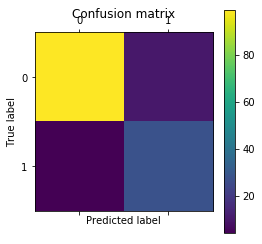

In [18]:
#confusion matrix, shows how model fit with data
cm = confusion_matrix(x_result, y_pred)
plt.matshow(cm)
plt.title('Confusion matrix')
plt.colorbar()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()